# Urban Mobility Insights: Predictive Traffic Analysis

This code demonstrates a machine learning approach for forecasting traffic patterns. It includes data preprocessing, feature selection using ExtraTreesClassifier, and the usage of XGBoost for prediction.

As a data scientist working with the government to transform our city into a smart city, I aim to enhance traffic management and infrastructure planning. Understanding traffic patterns at the four junctions, including holidays and special occasions, is crucial for forecasting and preparing for traffic peaks effectively.

### Importing Libraries

In [1]:
import os
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import xgboost as xgb
import seaborn as sns
from datetime import datetime
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
sns.set(color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing

In [2]:
df_train = pd.read_csv('/Users/mvshah10/Downloads/Smart_Traffic/train_data.csv', encoding='ISO-8859-1', engine='c')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [3]:
df_test = pd.read_csv('/Users/mvshah10/Downloads/Smart_Traffic/test_data.csv', encoding='ISO-8859-1', engine='c')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  11808 non-null  object
 1   Junction  11808 non-null  int64 
 2   ID        11808 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 276.9+ KB


### Converting to DateTime

In [4]:
df_train['DateTime'] = pd.to_datetime(df_train['DateTime'])
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  11808 non-null  datetime64[ns]
 1   Junction  11808 non-null  int64         
 2   ID        11808 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 276.9 KB


### DateTime Features Creation

In [5]:
# Creating features from DateTime for train data

df_test['Weekday'] = [datetime.weekday(date) for date in df_test.DateTime]
df_test['Year'] = [date.year for date in df_test.DateTime]
df_test['Month'] = [date.month for date in df_test.DateTime]
df_test['Day'] = [date.day for date in df_test.DateTime]
df_test['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_test.DateTime]
df_test['Week'] = [date.week for date in df_test.DateTime]
df_test['Quarter'] = [date.quarter for date in df_test.DateTime]

# Creating features from DateTime for test data

df_train['Weekday'] = [datetime.weekday(date) for date in df_train.DateTime]
df_train['Year'] = [date.year for date in df_train.DateTime]
df_train['Month'] = [date.month for date in df_train.DateTime]
df_train['Day'] = [date.day for date in df_train.DateTime]
df_train['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_train.DateTime]
df_train['Week'] = [date.week for date in df_train.DateTime]
df_train['Quarter'] = [date.quarter for date in df_train.DateTime]

### Feature Engineering

Feature ranking:
feature 0 : DateTime (0.372379)
feature 7 : Time (0.355801)
feature 6 : Day (0.066553)
feature 3 : Weekday (0.061836)
feature 2 : ID (0.052962)
feature 1 : Junction (0.047788)
feature 8 : Week (0.030817)
feature 5 : Month (0.007658)
feature 9 : Quarter (0.002293)
feature 4 : Year (0.001913)


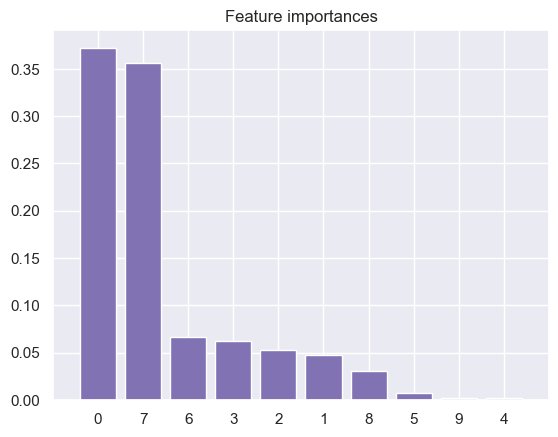

In [6]:
def datetounix(df):
    unixtime = []

    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))

    df['DateTime'] = unixtime
    return(df)

tree_clf = ExtraTreesClassifier()

df_train_features = df_train.drop(['Vehicles'], axis=1)

df_train_features = datetounix(df_train_features)

X = df_train_features.values

y = df_train['Vehicles'].values

tree_clf.fit(X, y)

importances = tree_clf.feature_importances_
feature_names = df_train_features.columns.tolist()

feature_imp_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)

indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

plt.figure(0)
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="m", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Traffic Histogram

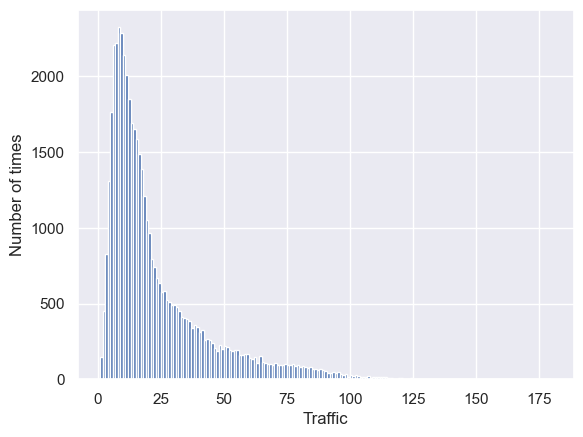

In [7]:
data = df_train.Vehicles
binwidth = 1
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth), log=False)
plt.xlabel("Traffic")
plt.ylabel("Number of times")
plt.show()

## Data preparation

In [8]:
df_test_features = datetounix(df_test.drop(['Year', 'Quarter', 'Month', 'ID'], axis=1))

X_test = df_test_features.values

df_train_features = df_train.drop(['Vehicles','Year', 'Quarter', 'Month', 'ID'], axis=1)

df_train_features = datetounix(df_train_features)

X = df_train_features.values

y = df_train['Vehicles'].values

## Decision Tree Classifier

In [9]:
df_solution = pd.DataFrame()
df_solution['ID'] = df_test.ID

start_time = time.time()

clf = DecisionTreeClassifier(criterion='gini', random_state = 13)

clf.fit(X, y)

predictions = clf.predict(X_test)

print("Execution time is %s seconds." % (time.time() - start_time))

df_solution['Vehicles'] = predictions
df_solution

Execution time is 0.5864460468292236 seconds.


,ID,Vehicles
0,20170701001,70
1,20170701011,62
2,20170701021,52
3,20170701031,39
4,20170701041,40
...,...,...
11803,20171031194,30
11804,20171031204,30
11805,20171031214,16
11806,20171031224,22


## XGBoost Algorithm

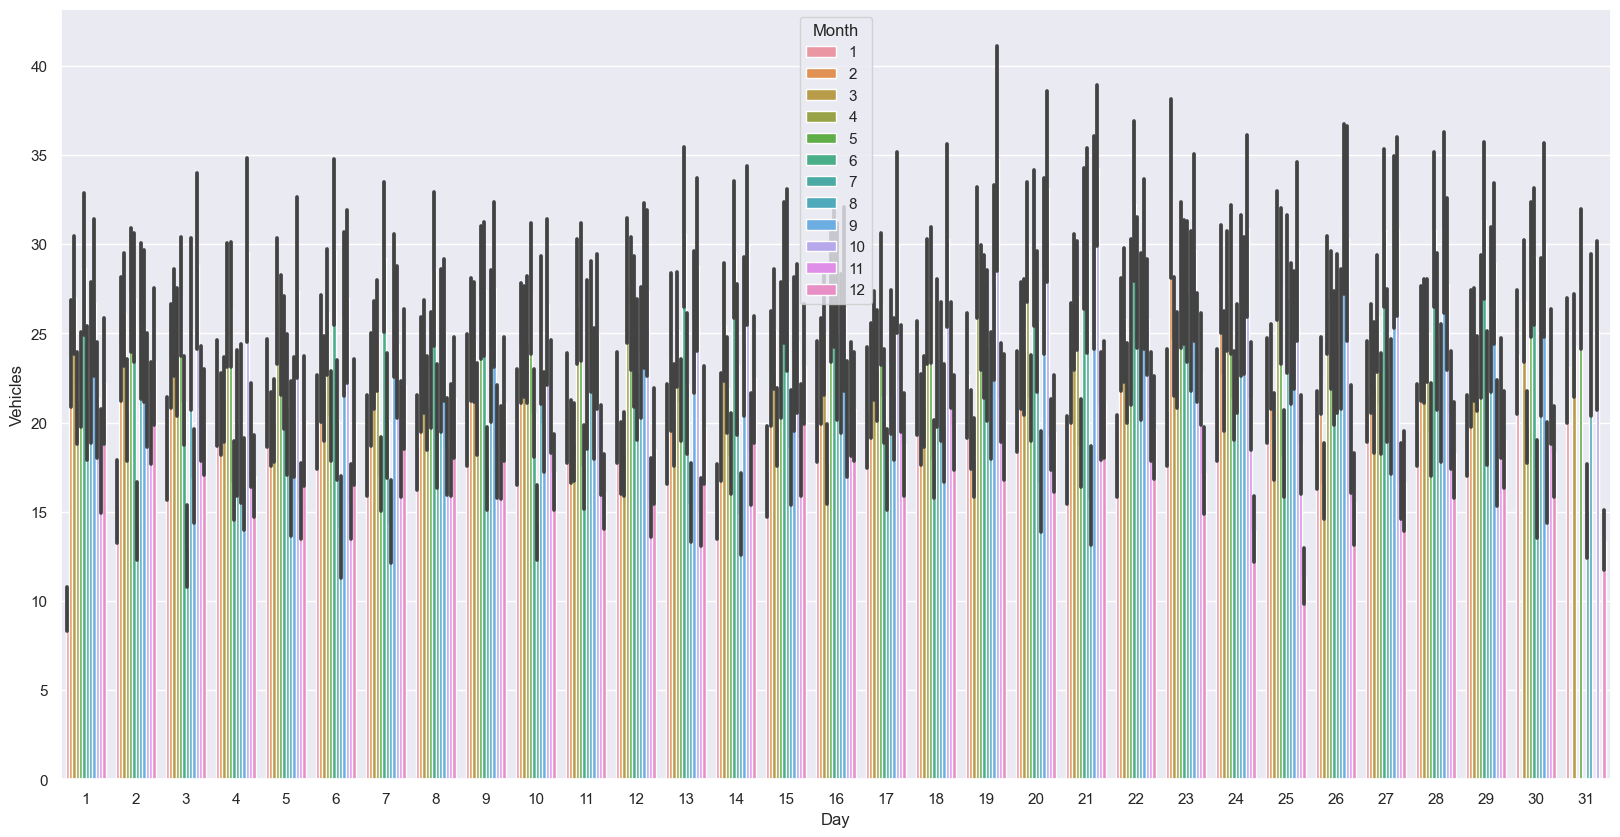

In [10]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="Day", y="Vehicles", hue='Month', data=df_train)

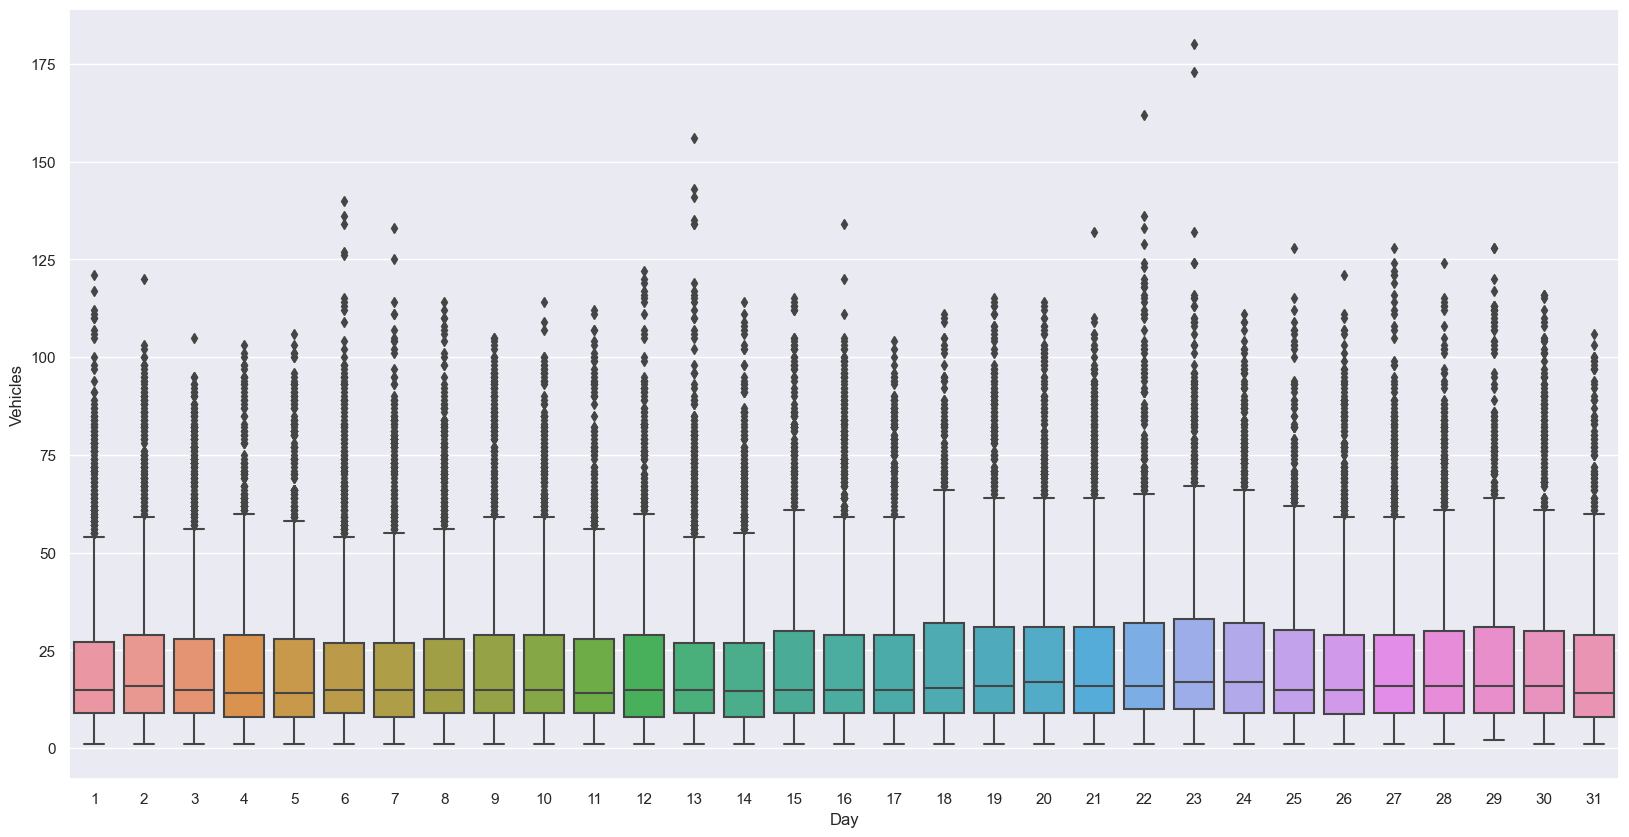

In [11]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="Day", y="Vehicles", data=df_train)

In [12]:
test_3= df_test[df_test['Junction']==3]
test_others= df_test[df_test['Junction']!=3]

In [13]:
y0 = df_train['Vehicles']
data0 = df_train[['Junction', 'Day', 'Month','Year']]
sub_test0 = test_3[['Junction', 'Day', 'Month','Year']]

In [14]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'error', math.sqrt(mean_squared_error(labels, preds))

X_train, X_test, y_train, y_test = train_test_split(data0, y0, test_size=0.25, random_state=1)

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)
d_test = xgb.DMatrix(sub_test0)

params = {  
    "n_estimators": 300 ,  
    "max_depth": 4 ,                  
    "learning_rate": 0.005 ,    
    "colsample_bytree": 1 ,     
    "subsample": 1 ,            
    "gamma": 0.1 ,              
    'reg_alpha': 10 ,           
    "min_child_weight": 4 ,     
    }

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

reg = xgb.train(params, d_train, 1000, watchlist,  feval = evalerror, maximize=False, verbose_eval=50)

Vehicles_test_3 = reg.predict(d_test)

[21:48:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:30.37507	train-error:30.37507	valid-rmse:30.16488	valid-error:30.16488
[50]	train-rmse:24.66901	train-error:24.66901	valid-rmse:24.50307	valid-error:24.50307
[100]	train-rmse:20.44241	train-error:20.44241	valid-rmse:20.31845	valid-error:20.31845
[150]	train-rmse:17.37700	train-error:17.37700	valid-rmse:17.28593	valid-error:17.28593
[200]	train-rmse:15.21206	train-error:15.21206	valid-rmse:15.15580	valid-error:15.15580
[250]	train-rmse:13.71975	train-error:13.71975	valid-rmse:13.70063	valid-error:13.70063
[300]	train-rmse:12.71541	train-error:12.71541	valid-rmse:12.73153	valid-error:12.73153
[350]	train-rmse:12.05516	train-error:12.05516	valid-rmse:12.10172	valid-error:12.10172
[400]	train-rmse:11.62550	train-error:11.62550	valid-rmse:11.69717	valid-error:11.69717
[450]	train-rmse:11.34935

In [15]:
y = df_train[df_train['Junction']!=3]['Vehicles']
data = df_train[df_train['Junction']!=3][['Junction', 'Day','Month','Year']]
sub_test = test_others[['Junction', 'Day', 'Month', 'Year']]

In [16]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'error', math.sqrt(mean_squared_error(labels, preds))

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=1)

d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)
d_test = xgb.DMatrix(sub_test)

params = {  
    "n_estimators": 280 ,  
    "max_depth": 3 ,              
    "learning_rate": 0.005 ,
    "colsample_bytree": 1 , 
    "subsample": 1 ,        
    "gamma": 0.1 ,              
    'reg_alpha': 1 ,   
    "min_child_weight": 2 ,     
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

reg = xgb.train(params, d_train, 1000, watchlist,  feval = evalerror, maximize=False, verbose_eval=50)

Vehicles_test_others = reg.predict(d_test)

[21:49:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-rmse:34.36836	train-error:34.36836	valid-rmse:35.30474	valid-error:35.30474
[50]	train-rmse:27.87580	train-error:27.87580	valid-rmse:28.67542	valid-error:28.67542
[100]	train-rmse:23.05246	train-error:23.05246	valid-rmse:23.75121	valid-error:23.75121
[150]	train-rmse:19.53438	train-error:19.53438	valid-rmse:20.15672	valid-error:20.15673
[200]	train-rmse:17.02932	train-error:17.02932	valid-rmse:17.59383	valid-error:17.59383
[250]	train-rmse:15.28270	train-error:15.28270	valid-rmse:15.81100	valid-error:15.81100
[300]	train-rmse:14.07707	train-error:14.07707	valid-rmse:14.58152	valid-error:14.58152
[350]	train-rmse:13.25366	train-error:13.25366	valid-rmse:13.73797	valid-error:13.73797
[400]	train-rmse:12.69066	train-error:12.69066	valid-rmse:13.15808	valid-error:13.15808
[450]	train-rmse:12.30975

In [17]:
ID_test_3= df_test[df_test['Junction']==3]['ID']
ID_test_others= df_test[df_test['Junction']!=3]['ID']

ID= pd.DataFrame()
ID= ID_test_others.append(ID_test_3)

Vehicles= pd.DataFrame()
Vehicles= np.concatenate((Vehicles_test_others,Vehicles_test_3))


prediction_4_months = pd.DataFrame({
        "ID": ID,
        "Vehicles": Vehicles 
    })
prediction_4_months

,ID,Vehicles
0,20170701001,69.015999
1,20170701011,69.015999
2,20170701021,69.015999
3,20170701031,69.015999
4,20170701041,69.015999
...,...,...
8851,20171031193,19.512072
8852,20171031203,19.512072
8853,20171031213,19.512072
8854,20171031223,19.512072
